<a href="https://colab.research.google.com/github/Firojpaudel/GenAI-Chronicles/blob/main/GANs/GAN_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Trying to implement GAN using PyTorch**: MNIST Dataset
---

In [25]:
##@ Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [21]:
## Hyperparameters and configs
n_epochs = 50
batch_size = 64
latent_dim = 100
img_size= 28
b1= 0.5
b2= 0.999
lr= 0.001 #Initial testing learning rate
channels = 1
sample_interval = 800

## Image shape
image_shape = (channels, img_size, img_size)

In [3]:
### Testing for GPU

cuda = torch.cuda.is_available()
cuda

True

In [23]:
### Creating the directory for saving the images
if os.path.exists('Generated_images'):
  shutil.rmtree('Generated_images')   ## will delete the directory and its contents
os.makedirs("Generated_images", exist_ok= True)

#### 1. Creating the Generator

In [5]:
##@ First lets create the generator nn

class Generator(nn.Module):
  def __init__(self, latent_dim, img_shape):
    super(Generator, self).__init__()
    self.img_shape = img_shape

    def block(in_features, out_features, normalize= True):
      layers = [nn.Linear(in_features, out_features)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_features, momentum=0.8))
      layers.append(nn.LeakyReLU(0.2, inplace= True))
      return layers

    self.model= nn.Sequential(
        *block(latent_dim, 128, normalize = False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, int(np.prod(img_shape))),  #Trying to match with the dimension of the image and then we apply the activation function
        nn.Tanh()
    )


  def forward(self, z):
    img = self.model(z)
    return img.view(img.size(0), *self.img_shape)

##### **Explaining the code above:** _Generator_

---


Okay, so first lets explain the block function and the need for it:

If we did not use block function the code snippet for `self.model` would look like:

```python
 self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),  # First layer
            nn.LeakyReLU(0.2, inplace=True),  # Activation
            nn.Linear(128, 256),  # Second layer
            nn.BatchNorm1d(256, momentum=0.8),  # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),  # Activation
            nn.Linear(256, 512),  # Third layer
            nn.BatchNorm1d(512, momentum=0.8),  # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),  # Activation
            nn.Linear(512, 1024),  # Fourth layer
            nn.BatchNorm1d(1024, momentum=0.8),  # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),  # Activation
            nn.Linear(1024, int(np.prod(img_shape))),  # Output layer
            nn.Tanh()  # Final activation function
        )

```

which is obviously very tough to handle. So we just created the function `"block"` which opens up in the model created.

> **_Note:_** \
When you call `*block(...)` inside `nn.Sequential`, the asterisk _unpacks the list of layers returned by the block function_. Without the asterisk, the code would pass the whole list as a single element, which would cause an error.

The same goes for ` *self.img_shape`. It's just unpacking the image dimensions



### 2. Creating the discriminator

In [6]:
##@ Now Creating the discriminator:

class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super(Discriminator, self).__init__()

    self.model= nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    return self.model(img_flat)

##### **Explaining the code above:** _Discriminator_

---

Okay, so here, its pretty straight forward. We create the model which has the final activation funciton of `sigmoid` and this simply classifies as real or fake.

> 1 being the absolute real image classification and 0 being the absolute fake image classification

Also lets discuss about the `img.view`:

Explaining with the example case,

Let's say we have a batch of **3 RGB images, each of size 64x64**:

- `img.shape` would be $(3, 3, 64, 64)$ ie. $(\text{batch_size}, \text{channels}, \text{height}, \text{width})$.

`img.view(img.size(0), -1)` would do the following:
- `img.size(0)` is 3 (the batch size).
- `-1` calculates $3 * 64 * 64 = 12288$.

The resulting shape would be (3, 12288)

#### 3. Initialize the Generator and Discriminator

In [7]:
generator= Generator(latent_dim= latent_dim, img_shape= image_shape)
discriminator = Discriminator(img_shape=image_shape)

#### 4. Moving the models to GPU if available

In [8]:
if cuda:
  generator.cuda()
  discriminator.cuda()

#### 5. Defining the Loss Function

In [9]:
##@ Loss Function

adversarial_loss = torch.nn.BCELoss() #The adversarial loss is simply Binary Cross Entropy Loss
if cuda:
  adversarial_loss.cuda()

#### 6. Optimizers for Generator and Discriminator

In [10]:
optimizer_Gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_Dis = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

#### 7. Preping the data

In [11]:
dataloader= DataLoader(
    datasets.MNIST(
        "./data/MNIST",
        train= True,
        download= True,
        transform= transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  #Normalizing to [-1, 1]
        ])
    ),
    batch_size= batch_size,
    shuffle= True
)

#### 8. Training Loop

In [12]:
## Type of Tensor
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
## Loop starts:

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    #Adversarial Ground Truths
    valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad= False)
    fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad= False)

    # Real Images
    real_imgs = Variable(imgs.type(Tensor))

    ##@ Training The Generator:
    optimizer_Gen.zero_grad()  ### Clearing the previous gradients

    # Generating the noise and fake images
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
    gen_imgs = generator(z)

    # Generator Loss: Fool the discriminator to think the images generated are real
    gen_loss = adversarial_loss(discriminator(gen_imgs), valid)

    #Backprop
    gen_loss.backward()
    # Update the weights
    optimizer_Gen.step()

    ##@ Training the Discriminator:
    optimizer_Dis.zero_grad()

    # Discriminator loss
    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    dis_loss= (real_loss + fake_loss)/2

    #Backprop
    dis_loss.backward()
    #Update the weights
    optimizer_Dis.step()

    ##@ Logging:
    print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}]"
          f"[D loss: {dis_loss.item():.4f}] [G loss: {gen_loss.item():.4f}]")

    # Saving the generated outputs periodically
    if i % sample_interval == 0:
      save_image(gen_imgs.data[:25], f"Generated_images/{epoch}_{i}.png", nrow=5, normalize=True)

## Trainig Complete
print("Training Complete! Check the 'Generated_images' folder for the outputs")

> _**Note**:_  
The training-process outputs are cleared during pushing.

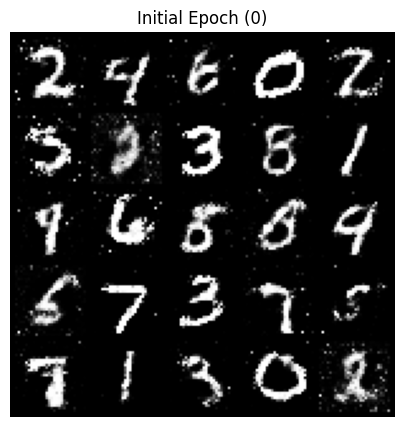

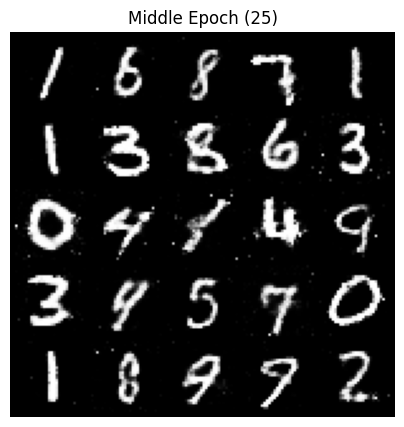

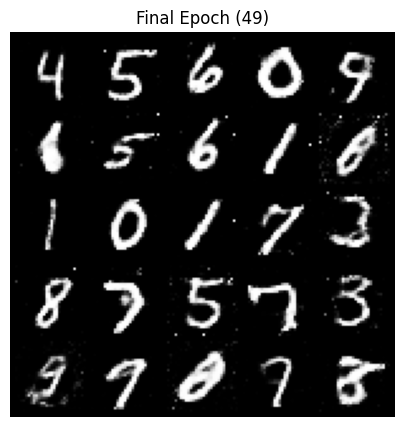

In [30]:
##@ Inspecting the generated images quality over time:

#defining the path first:
initial_path = "Generated_images/0_0.png"
middle_path = f"Generated_images/{n_epochs // 2}_0.png"
final_path = f"Generated_images/{n_epochs-1}_0.png"

progress_path= "Generated_images/progress.png"

# Function to load and display an image from a file path
def show_image(image_path, title="Image"):
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.show()
    else:
        print(f"Image not found: {image_path}")

# Display initial, middle, and final images
show_image(initial_path, title="Initial Epoch (0)")
show_image(middle_path, title=f"Middle Epoch ({n_epochs // 2})")
show_image(final_path, title=f"Final Epoch ({n_epochs - 1})")


Finally, the Basic GAN using pytorch is implemented!

---